# PyTorch Batched K-Means

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

device = "cuda:0"
torch.manual_seed(0)

B = 3
N = 10000
C = 2
K = 13

x = 2 * torch.randn(B, N, C, device=device) * torch.tensor([0.3, 0.5], device=device)
seed = 0
temp = 1.0
max_iters = 20
tol = 1e-6

## MSE

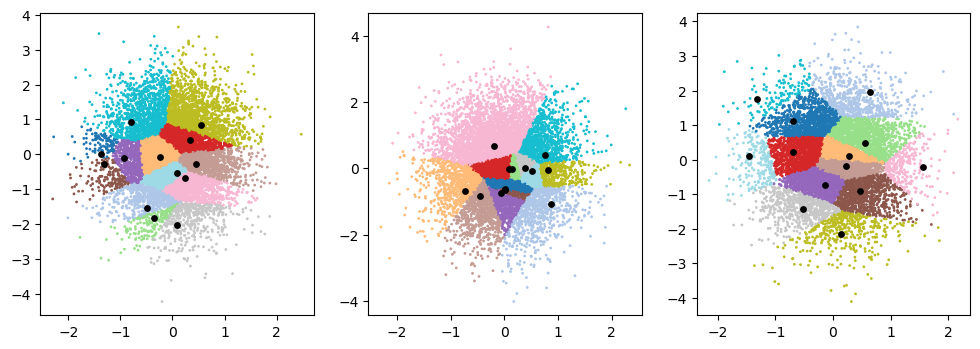

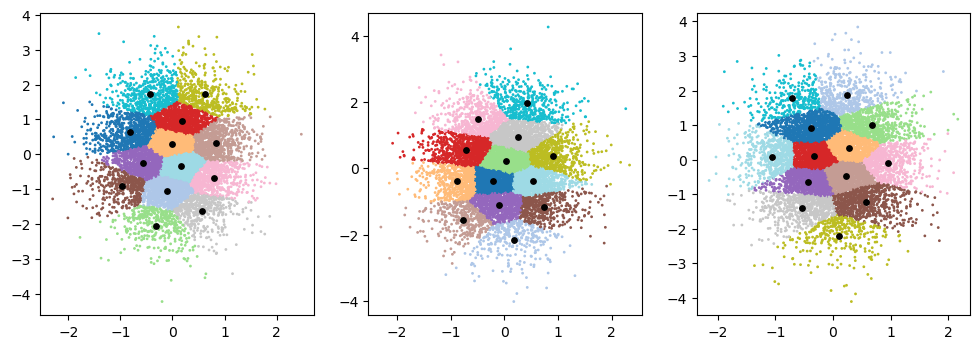

In [2]:
# [B K] indexes of the initial centroids
rng = np.random if seed is None else np.random.default_rng(seed)
idx = torch.from_numpy(rng.choice(N, size=(B, K), replace=True)).to(x.device)

# [B K C] gather centroids from x using the sampled indexes
centroids = x.detach().gather(dim=1, index=idx[:, :, None].expand(-1, -1, C))

fig, axs = plt.subplots(1, B, figsize=(B * 4, 4), dpi=100)
mse = (centroids[:, None, :, :] - x[:, :, None, :]).pow_(2).sum(dim=-1)
idx = mse.argmin(dim=-1)
for b, ax in enumerate(axs):
    ax.scatter(*x[b].cpu().numpy().T, c=idx[b].cpu().numpy(), cmap="tab20", s=1)
for b, ax in enumerate(axs):
    ax.scatter(*centroids[b].cpu().numpy().T, color="black", s=15)
fig.set_facecolor("white")
display(fig)
plt.close(fig)

for i in range(max_iters):
    # [B N K] mean squared error between each point and each centroid
    mse = (centroids[:, None, :, :] - x[:, :, None, :]).pow_(2).sum(dim=-1)

    # [B N] assign the closest centroid to each sample
    idx = mse.argmin(dim=-1)

    # [B K] how many samples are assigned to each centroid?
    counts = (
        idx.new_zeros(B, K)
        .scatter_add_(dim=1, index=idx, src=idx.new_ones(B, N))
        .clamp_min(1)
    )

    # [B K C] for each centroid, sum of all samples assigned to it
    new_centroids = torch.zeros_like(centroids)
    new_centroids.scatter_add_(dim=1, index=idx[:, :, None].expand(-1, -1, C), src=x)
    new_centroids.div_(counts[:, :, None])

    error = centroids.sub_(new_centroids).abs_().max()
    centroids = new_centroids
    if error.item() < tol:
        break

fig, axs = plt.subplots(1, B, figsize=(B * 4, 4), dpi=100)
mse = (centroids[:, None, :, :] - x[:, :, None, :]).pow_(2).sum(dim=-1)
idx = mse.argmin(dim=-1)
for b, ax in enumerate(axs):
    ax.scatter(*x[b].cpu().numpy().T, c=idx[b].cpu().numpy(), cmap="tab20", s=1)
for b, ax in enumerate(axs):
    ax.scatter(*centroids[b].cpu().numpy().T, color="black", s=15)
fig.set_facecolor("white")
display(fig)
plt.close(fig)

## Cosine

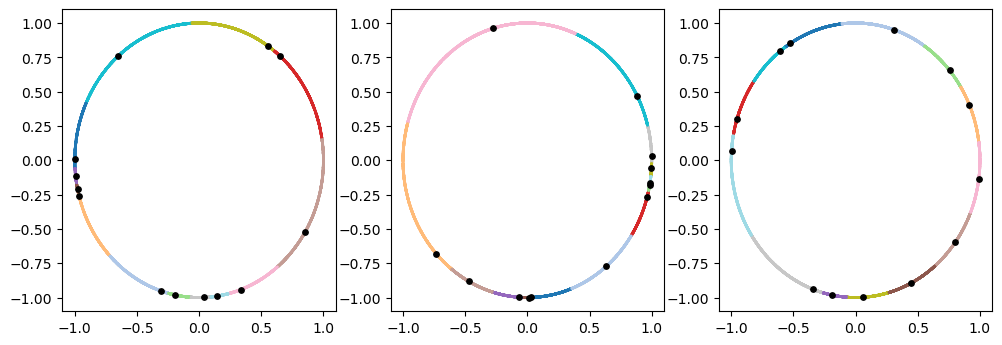

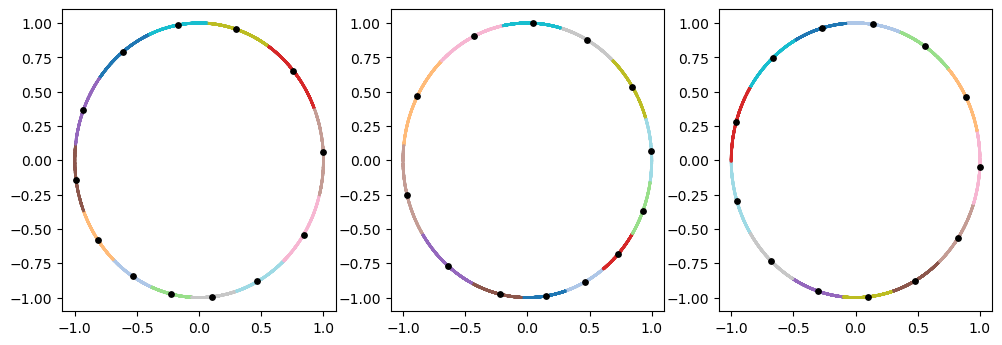

In [3]:
x = x / torch.linalg.vector_norm(x, dim=-1, keepdim=True)

# [B K] indexes of the initial centroids
rng = np.random if seed is None else np.random.default_rng(seed)
idx = torch.from_numpy(rng.choice(N, size=(B, K), replace=True)).to(x.device)

# [B K C] gather centroids from x using the sampled indexes
centroids = x.detach().gather(dim=1, index=idx[:, :, None].expand(-1, -1, C))

fig, axs = plt.subplots(1, B, figsize=(B * 4, 4), dpi=100)
mse = (centroids[:, None, :, :] - x[:, :, None, :]).pow_(2).sum(dim=-1)
idx = mse.argmin(dim=-1)
for b, ax in enumerate(axs):
    ax.scatter(*x[b].cpu().numpy().T, c=idx[b].cpu().numpy(), cmap="tab20", s=1)
for b, ax in enumerate(axs):
    ax.scatter(*centroids[b].cpu().numpy().T, color="black", s=15)
fig.set_facecolor("white")
display(fig)
plt.close(fig)

for i in range(max_iters):
    # [B N K] cosine between each point and each centroid
    cos = torch.einsum("bnc, bkc -> bnk", x, centroids)

    # [B N] assign the closest centroid to each sample
    idx = cos.argmax(dim=-1)

    # [B K] how many samples are assigned to each centroid?
    counts = (
        idx.new_zeros(B, K)
        .scatter_add_(dim=1, index=idx, src=idx.new_ones(B, N))
        .clamp_min(1)
    )

    # [B K C] for each centroid, sum of all samples assigned to it
    new_centroids = torch.zeros_like(centroids)
    new_centroids.scatter_add_(dim=1, index=idx[:, :, None].expand(-1, -1, C), src=x)
    new_centroids.div_(counts[:, :, None])
    new_centroids.div_(torch.linalg.vector_norm(new_centroids, dim=-1, keepdim=True))

    error = centroids.sub_(new_centroids).abs_().max()
    centroids = new_centroids
    if error.item() < tol:
        break

fig, axs = plt.subplots(1, B, figsize=(B * 4, 4), dpi=100)
mse = (centroids[:, None, :, :] - x[:, :, None, :]).pow_(2).sum(dim=-1)
idx = mse.argmin(dim=-1)
for b, ax in enumerate(axs):
    ax.scatter(*x[b].cpu().numpy().T, c=idx[b].cpu().numpy(), cmap="tab20", s=1)
for b, ax in enumerate(axs):
    ax.scatter(*centroids[b].cpu().numpy().T, color="black", s=15)
fig.set_facecolor("white")
display(fig)
plt.close(fig)